In [120]:
import os
import csv
import sys
import copy
import time
import logging
import datetime
import numpy as np
#from stats import *
import pandas as pd
import seaborn as sns
from scipy import stats
#from Layer import Layer
import tensorflow as tf 
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow_transform as tft
from sklearn.decomposition import PCA
from keras.utils.vis_utils import plot_model
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_california_housing, make_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [121]:
from sklearn import preprocessing

def write_stats(samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mae_train, residual_train):
    with open('../data/stats.csv', 'a') as f:
        newrow = [samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mae_train, residual_train]
        writer = csv.writer(f)
        writer.writerow(newrow)

def fill_dataset(dataframe: DataFrame):
    for column in dataframe:
        if dataframe[column].dtype != 'object':
            dataframe[column] = dataframe[column].fillna(dataframe[column].mean())
    return dataframe

def normalize_dataset(X):
    return tf.divide(
        X - tf.reduce_min(X, axis=0),
        tf.reduce_max(X, axis=0) - tf.reduce_min(X, axis=0)
    )

def denormalize(x_norm, mean, std):
    return (x_norm * std[3]) + mean[3]

def normalize(X):
    return tf.keras.utils.normalize(X)

def stdev(x):
    return tf.square(tf.divide(tf.reduce_sum((x - tf.divide(tf.reduce_sum(x), len(x)))**2), len(x)-1))

def remove_outliers(X, threshold=7):
    z = np.abs(stats.zscore(X))
    return X[(z<threshold).all(axis=1)][:, 0:-1], X[(z<threshold).all(axis=1)][: ,-1]

def make_dataset(X_data,y_data,k):
    X_data, y_data = remove_outliers(np.concatenate([X_data, y_data], axis=1))
    def gen():
        for train_index, test_index in KFold(k).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            XN_train, XN_test = normalize_dataset(X_data[train_index]), normalize_dataset(X_data[test_index])
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,XN_train,y_train,X_test,XN_test,y_test

    return tf.data.Dataset.from_generator(gen, (tf.double,tf.double,tf.double,tf.double,tf.double,tf.double))

def fill_dataset(dataset):
    data = dataset.copy()
    for col in data.columns:
        data[col].fillna(data[col].mean())
    return data

In [122]:
stocks = pd.read_csv("../data/datasets/all_stocks_5yr.csv")
stocks = pd.DataFrame(stocks)
rnnstocks = stocks.drop(["Name", "date"], axis=1)[len(stocks.values)-1000:-1]
rnnstocks.head()

,open,high,low,close,volume
618040,29.74,30.17,29.64,29.97,4699291
618041,29.99,30.03,29.53,29.61,3235700
618042,29.78,30.07,29.62,29.70,3106683
618043,29.56,30.38,29.55,30.13,4412585
618044,30.04,30.45,30.00,30.40,3647374


In [123]:
total_columns=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
k = 2
batch_size = 120
dates = stocks['date'][len(stocks.values)-1000:-1]
rnnstocks = rnnstocks.values
rnnstocks = pd.DataFrame(rnnstocks)
rnnstocks = fill_dataset(rnnstocks)
rnnstocks = pd.DataFrame(rnnstocks)
rnnstocks.columns = stocks.drop(["Name", "date"], axis=1).columns
n = len(rnnstocks)
_, n_features = rnnstocks.shape

pca = PCA(n_components=3)
pca.fit(rnnstocks.values)


train_data = rnnstocks[0:int(n*0.7)]
val_data = rnnstocks[int(n*0.7):int(n*0.9)]
test_data = rnnstocks[int(n*0.9):]
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std


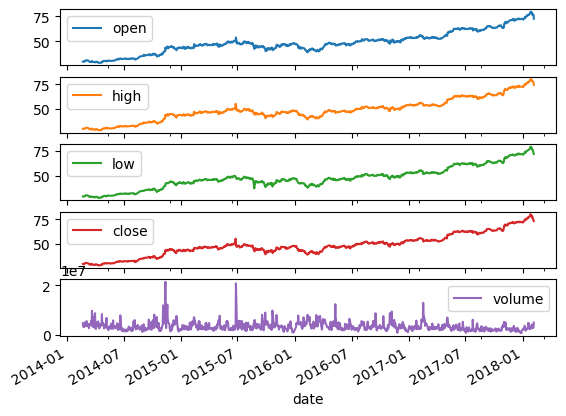

In [124]:
date_time = pd.to_datetime(dates, format='%Y-%m-%d')

plot_features = rnnstocks[rnnstocks.columns]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

In [125]:
rnnstocks.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
open,999.0,4.849747e+01,1.105057e+01,28.480,4.289500e+01,47.33,53.500,79.81
high,999.0,4.891713e+01,1.109932e+01,28.570,4.338500e+01,47.72,53.895,80.13
low,999.0,4.806548e+01,1.101670e+01,28.135,4.230250e+01,46.94,53.240,79.38
close,999.0,4.851888e+01,1.105020e+01,28.400,4.287500e+01,47.34,53.540,80.09
volume,999.0,3.411189e+06,1.884292e+06,710499.000,2.254894e+06,2956572.00,4088199.000,21414898.00


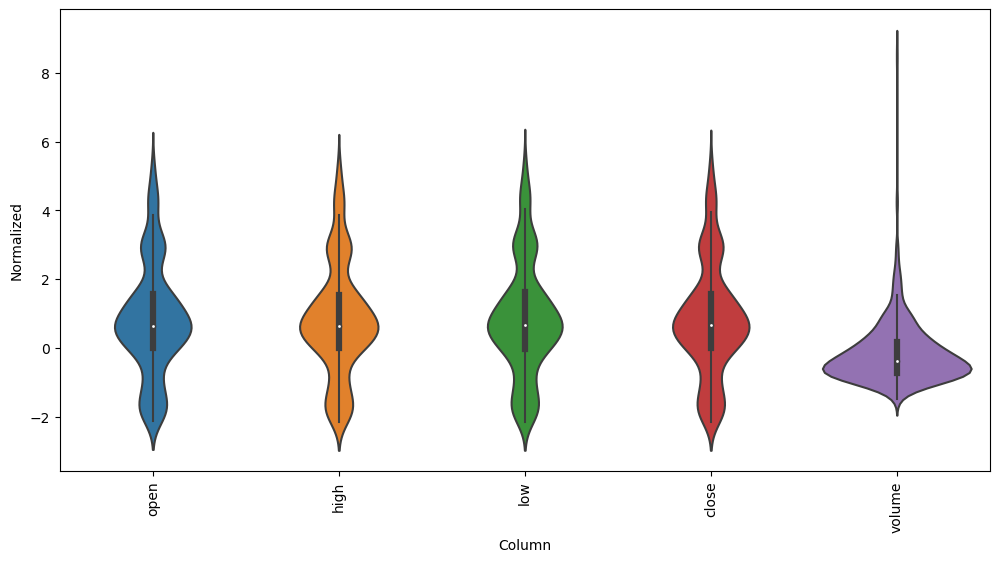

In [126]:
rnnstocks_std = (rnnstocks - train_mean) / train_std
rnnstocks_std = rnnstocks_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=rnnstocks_std)
_ = ax.set_xticklabels(rnnstocks.keys(), rotation=90)

In [127]:
class WindowGenerator():
  def __init__(self, train_df, val_df, test_df, input_width, label_width, shift,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels
  
  def plot(self, model=None, plot_col='close', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col}')
      plt.plot(self.input_indices, denormalize(inputs[n, :, plot_col_index], train_mean, train_std),
              label='Inputs')

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue
      
      plt.plot(self.label_indices, denormalize(labels[n, :, label_col_index], train_mean, train_std),
                  label='Labels', c='#2ca02c')
      if model is not None:
        predictions = model(inputs)
        plt.plot(self.label_indices, denormalize(predictions[n, :, label_col_index], train_mean, train_std),
                    label='Predictions',
                    c='#ff7f0e')

      if n == 0:
        plt.legend()
    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
  
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    result = getattr(self, '_example', None)
    if result is None:
      result = next(iter(self.train))
      self._example = result
    return result

In [128]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
      super().__init__()
      self.label_index = label_index
      
    def __call__(self, inputs, training=False):
      if self.label_index is None:
        return inputs
      result = inputs[:, :, self.label_index]
      return result[:, :, tf.newaxis]

In [129]:
CONV_WIDTH = 100
column_indices = {name: i for i, name in enumerate(rnnstocks.columns)}
window = WindowGenerator(
    train_data, val_data, test_data,
    input_width=CONV_WIDTH, label_width=CONV_WIDTH, shift=10,
    label_columns=['close']
)
window

Total window size: 110
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Label indices: [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109]
Label column name(s): ['close']

In [130]:
baseline = Baseline(label_index=column_indices['close'])
baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
#val_performance['Baseline'] = baseline.evaluate(x=window.val)
#performance['Baseline'] = baseline.evaluate(x=window.test, verbose=0)

In [131]:
EPOCHS = 100
PATIENCE = 2
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64 ,return_sequences=True),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(units=1),
])

In [132]:
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.RootMeanSquaredError()])
history = model.fit(window.train , epochs=EPOCHS, validation_data=window.val, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error', patience=PATIENCE, mode='min')])

Epoch 1/100
19/19 [==============================] - 5s 96ms/step - loss: 0.3813 - root_mean_squared_error: 0.6175 - val_loss: 3.5729 - val_root_mean_squared_error: 1.8902
Epoch 2/100
19/19 [==============================] - 1s 60ms/step - loss: 0.1737 - root_mean_squared_error: 0.4167 - val_loss: 1.5930 - val_root_mean_squared_error: 1.2622
Epoch 3/100
19/19 [==============================] - 1s 60ms/step - loss: 0.1250 - root_mean_squared_error: 0.3535 - val_loss: 0.9715 - val_root_mean_squared_error: 0.9856
Epoch 4/100
19/19 [==============================] - 1s 62ms/step - loss: 0.1098 - root_mean_squared_error: 0.3314 - val_loss: 0.7610 - val_root_mean_squared_error: 0.8724
Epoch 5/100
19/19 [==============================] - 1s 59ms/step - loss: 0.1016 - root_mean_squared_error: 0.3188 - val_loss: 0.4959 - val_root_mean_squared_error: 0.7042
Epoch 6/100
19/19 [==============================] - 1s 66ms/step - loss: 0.0960 - root_mean_squared_error: 0.3099 - val_loss: 0.4654 - val_

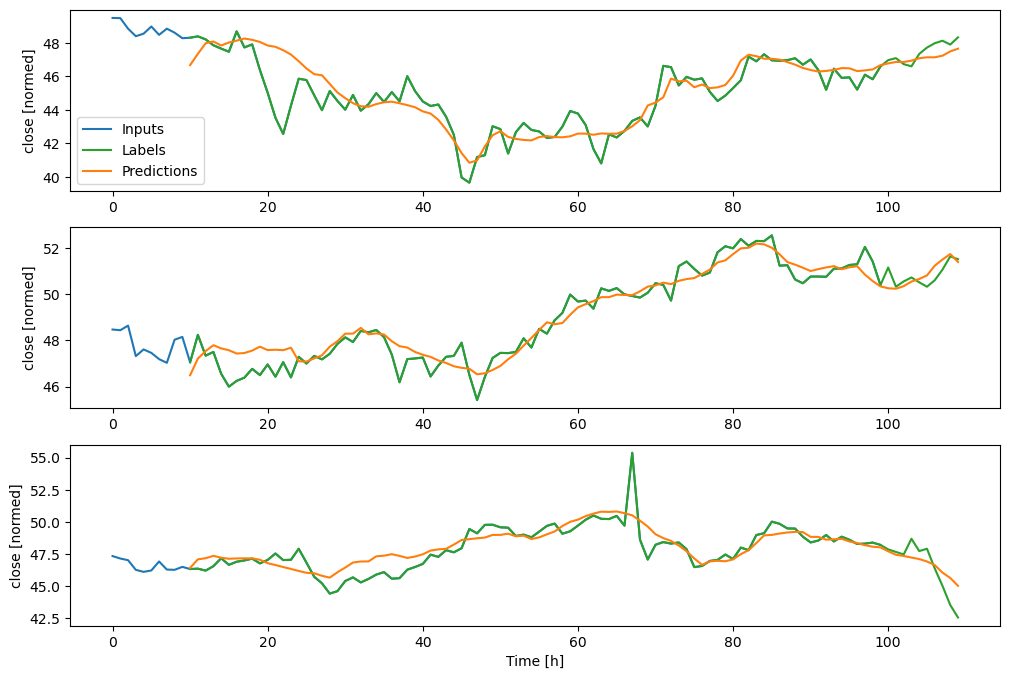

In [133]:
window.plot(model)